<a href="https://colab.research.google.com/github/ivan1003hsu/python_work/blob/master/for_CP/HW_VAE_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

載入資料和讀需要套件

In [0]:
import numpy as np
import matplotlib.pyplot as plt
# Import some useful packages
import tensorflow as tf
import tensorflow.keras.backend as K

# Layers for FNN
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate, BatchNormalization, Add, ReLU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Flatten, Reshape

# Optimizers for training
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics

# Losses for training
from tensorflow.keras import losses

# For data preprocessing
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

In [2]:
# Load dataset
(X_train, y_train0), (X_test, y_test0) = datasets.mnist.load_data()

# Reshape size
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

# Normalize the range of featurs
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()

# One-hot encoding
y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
# 抽驗函數
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

建立模型:
* 為了美觀，我希望至少output是對稱的

In [0]:
# Encoder part

inputx = Input(shape=(784,))
x = Reshape((28,28,1))(inputx)
x = Conv2D(4, (3,3), padding='same', activation='sigmoid')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
#shape:14,14,4
x = Conv2D(8, (3,3), padding='same', activation='sigmoid')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
#shape:7,7,8
x = Flatten()(x)
x = Dense(128, activation='sigmoid')(x)

Enc_mean = Dense(2)(x)
Enc_log_var = Dense(2)(x)

#Decoder part

z_input = Input(shape=(2,))
dec_0 = Dense(7*7*8, activation='sigmoid')
dec_1 = Reshape((7,7,8))
dec_2 = Conv2DTranspose(8, (2,2), strides=2, padding='valid', activation='sigmoid')
dec_3 = Conv2DTranspose(4, (2,2), strides=2, padding='valid', activation='sigmoid')
dec_4 = Conv2DTranspose(1, (2,2), strides=1, padding='same', activation='sigmoid')
dec_f = Flatten()
x_hat = dec_f(dec_4(dec_3(dec_2(dec_1(dec_0(z_input))))))
#x_hat = dec_3(dec_2(dec_1(dec_0(z_input))))


#Enccoder model
VAE_Encoder = Model(inputs=inputx, outputs=[Enc_mean,Enc_log_var])

#Decoder model
VAE_Decoder = Model(inputs=z_input, outputs=x_hat)

#VAE model
z = Lambda(sampling, output_shape=(2,))([Enc_mean,Enc_log_var])
x_hat = dec_f(dec_4(dec_3(dec_2(dec_1(dec_0(z))))))
#x_hat = dec_3(dec_2(dec_1(dec_0(z))))
VAE = Model(inputs=inputx, outputs=x_hat)

In [28]:
VAE_Encoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 28, 28, 1)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 4)    40          reshape_2[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 4)    0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [29]:
VAE_Decoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_7 (Dense)              (None, 392)               1176      
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 8)         264       
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 28, 28, 4)         132       
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 1)         17        
_________________________________________________________________
flatten_3 (Flatten)          (None, 784)               0   

In [30]:
VAE.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 28, 28, 1)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 4)    40          reshape_2[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 4)    0           conv2d_2[0][0]                   
____________________________________________________________________________________________

以下照抄

損失函數：

In [0]:
reconstruction_loss = 784 * losses.mean_squared_error(inputx, x_hat)

kl_loss = 1 + Enc_log_var - K.square(Enc_mean) - K.exp(Enc_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)

VAE.add_loss(vae_loss)

In [0]:
VAE.compile(optimizer=Adam())

In [33]:
mycallback = [tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=False)]

VAE.fit(X_train, X_train, 
        callbacks=mycallback,
        batch_size = 8192, 
        epochs = 500)

Epoch 1/500
8/8 [==============================] - 23s 3s/step - loss: 210.8588
Epoch 2/500
8/8 [==============================] - 23s 3s/step - loss: 195.0867
Epoch 3/500
8/8 [==============================] - 23s 3s/step - loss: 180.6581
Epoch 4/500
8/8 [==============================] - 23s 3s/step - loss: 167.5188
Epoch 5/500
8/8 [==============================] - 23s 3s/step - loss: 155.7037
Epoch 6/500
8/8 [==============================] - 23s 3s/step - loss: 145.1996
Epoch 7/500
8/8 [==============================] - 23s 3s/step - loss: 135.9890
Epoch 8/500
8/8 [==============================] - 23s 3s/step - loss: 127.9213
Epoch 9/500
8/8 [==============================] - 23s 3s/step - loss: 120.9398
Epoch 10/500
8/8 [==============================] - 23s 3s/step - loss: 114.9323
Epoch 11/500
8/8 [==============================] - 23s 3s/step - loss: 109.7687
Epoch 12/500
8/8 [==============================] - 23s 3s/step - loss: 105.3578
Epoch 13/500
8/8 [===================

KeyboardInterrupt: ignored

In [0]:
VAE.save_weights('VAE_CNN_weight.h5')

In [9]:
import os
from google.colab import drive
drive.mount('/content/drive/')

path = "/content/drive/My Drive/Colab Notebooks/"

os.chdir(path)
os.listdir(path)
VAE.load_weights('VAE_CNN_weight.h5')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


Encoder 視覺化

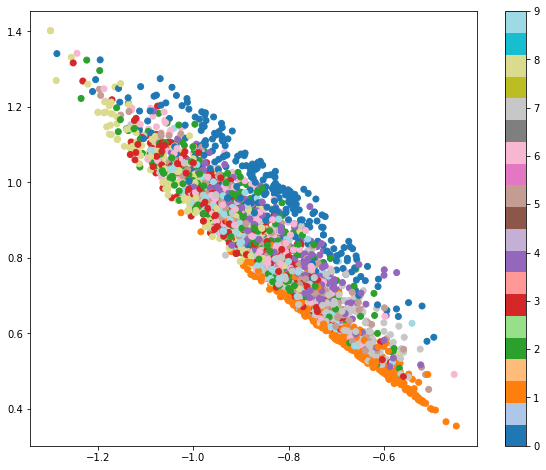

In [35]:
indices = np.random.randint(X_train.shape[0], size=3000)
VAE_latents = VAE_Encoder.predict(X_train[indices])[0]

plt.figure(figsize=(10, 8))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indices], cmap='tab20')
plt.colorbar()
plt.show()

Decoder 視覺化

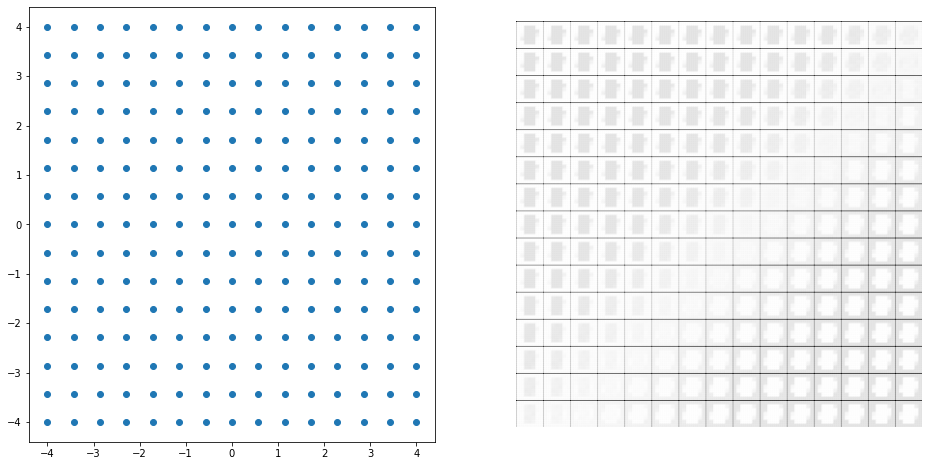

In [37]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[(n-i-1) * digit_size: (n - i) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
XX, YY = np.meshgrid(grid_x, grid_y)
plt.scatter(XX, YY)

plt.subplot(1, 2, 2)
plt.imshow(figure, cmap='Greys')
plt.axis('off')
plt.show()


結論：decoder很奇怪，或許可以試試zeropadding再做conv